# Imports

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pickle
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.metrics import Precision, Recall

# Configurations

In [37]:
ANNOTATION_FILE = "annotation.csv" 
AUDIO_FOLDER = "./ICBHI_final_database_preprocessed_normalized" 
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
EPOCHS = 20

# Load annotations

In [5]:
annotations = pd.read_csv(ANNOTATION_FILE, sep="\t", header=None, names=["id", "label"])
id_to_label = dict(zip(annotations.id.astype(str), annotations.label))

# Process audio to spectrogram

In [6]:
def wav_to_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mels_db = librosa.power_to_db(mels, ref=np.max)
    return mels_db

In [7]:
def create_dataset():
    X, y = [], []
    for fname in os.listdir(AUDIO_FOLDER):
        if fname.endswith(".wav"):
            patient_id = fname.split("_")[0]
            if patient_id in id_to_label:
                file_path = os.path.join(AUDIO_FOLDER, fname)
                mel = wav_to_mel_spectrogram(file_path)
                mel = tf.image.resize(mel[..., np.newaxis], (IMG_HEIGHT, IMG_WIDTH)).numpy()
                mel = np.repeat(mel, 3, axis=-1)  
                X.append(mel)
                y.append(id_to_label[patient_id])
    return np.array(X), np.array(y)

print("Processing data...")
X, y = create_dataset()

Processing data...


# Encode labels

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train/Test split

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

# Build model

In [2]:
base_model = ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights="imagenet")
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
out = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',Recall(),Precision()])

model.summary()

NameError: name 'IMG_HEIGHT' is not defined

# Train

In [25]:
y_val.shape

(284, 8)

In [38]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

Epoch 1/20
71/71 [==============================] - 7s 72ms/step - loss: 0.0293 - accuracy: 0.9947 - recall: 0.9938 - precision: 0.9947 - val_loss: 0.4256 - val_accuracy: 0.9049 - val_recall: 0.8908 - val_precision: 0.9036
Epoch 2/20
71/71 [==============================] - 4s 52ms/step - loss: 0.0135 - accuracy: 0.9991 - recall: 0.9965 - precision: 0.9991 - val_loss: 0.4456 - val_accuracy: 0.8944 - val_recall: 0.8944 - val_precision: 0.8975
Epoch 3/20
71/71 [==============================] - 4s 52ms/step - loss: 0.0080 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.3723 - val_accuracy: 0.9155 - val_recall: 0.9085 - val_precision: 0.9214
Epoch 4/20
71/71 [==============================] - 4s 52ms/step - loss: 0.0077 - accuracy: 0.9982 - recall: 0.9982 - precision: 0.9982 - val_loss: 0.3923 - val_accuracy: 0.8979 - val_recall: 0.8944 - val_precision: 0.9007
Epoch 5/20
71/71 [==============================] - 4s 51ms/step - loss: 0.0100 - accuracy: 0.9982 - recall:

In [39]:
model.save("resnet_audio_classifier.h5")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Training complete and model saved.")

Training complete and model saved.


# Loding Model

In [57]:
model = tf.keras.models.load_model("resnet_audio_classifier.h5")
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

IMG_HEIGHT, IMG_WIDTH = 224, 224



# Model evaluation

In [42]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Prédictions du modèle
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Labels vrais (ajuste selon ton format)
y_true = np.argmax(y_val, axis=1) if y_val.ndim == 2 else y_val

# Calcul du F1 score macro
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 score (macro) :", f1)

# Rapport complet
print(classification_report(y_true, y_pred))

9/9 [==============================] - 1s 109ms/step
F1 score (macro) : 0.866211987169434
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.82      0.88      0.85        16
           2       0.78      0.78      0.78        18
           3       0.99      0.96      0.97       159
           4       0.94      0.71      0.81        21
           5       0.83      1.00      0.91        15
           6       0.84      0.95      0.89        22
           7       0.71      0.81      0.76        21

    accuracy                           0.92       284
   macro avg       0.85      0.89      0.87       284
weighted avg       0.92      0.92      0.92       284



### Predictions

In [62]:
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1) if y_val.ndim == 2 else y_val

9/9 [==============================] - 1s 108ms/step


### Classes

In [63]:
classes = label_encoder.classes_
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

### F1-Scores

In [64]:
print("F1 macro :", f1_score(y_true, y_pred, average='macro'))
print("F1 micro :", f1_score(y_true, y_pred, average='micro'))
print("F1 weighted :", f1_score(y_true, y_pred, average='weighted'))

F1 macro : 0.866211987169434
F1 micro : 0.9154929577464789
F1 weighted : 0.91622699400344


### Résultats :
* Macro F1 = 0.866

* Micro F1 = 0.915

* Weighted F1 = 0.916

##  Signification des types de F1-score :
### F1 Macro (F1_macro = 0.866)
* Calcule le F1-score indépendamment pour chaque classe, puis fait la moyenne simple.

* N’implique pas les proportions (déséquilibre) des classes dans le calcul.

### F1 Micro (F1_micro = 0.915)
* Regroupe les vrais positifs (TP), faux positifs (FP) et faux négatifs (FN) de toutes les classes avant de calculer le F1-score.

* Favorise naturellement les classes majoritaires, car le calcul est dominé par leur fréquence.

### F1 Weighted (F1_weighted = 0.916)
* Calcule un F1-score par classe, puis fait une moyenne pondérée selon le nombre d’échantillons (support) dans chaque classe.

* Idéal pour les jeux de données déséquilibrés, car il reflète la réalité du dataset.

### Commentaire global
Les scores F1 montrent que ton modèle est très performant globalement (micro et weighted > 0.91).
Le score macro relativement élevé (0.866) indique qu’il ne sacrifie pas la performance sur les classes minoritaires, ce qui est essentiel dans un contexte déséquilibré.
Le faible écart entre macro, micro, et weighted suggère que le modèle généralise bien tout en étant juste entre classes.

# Matrice de confusion

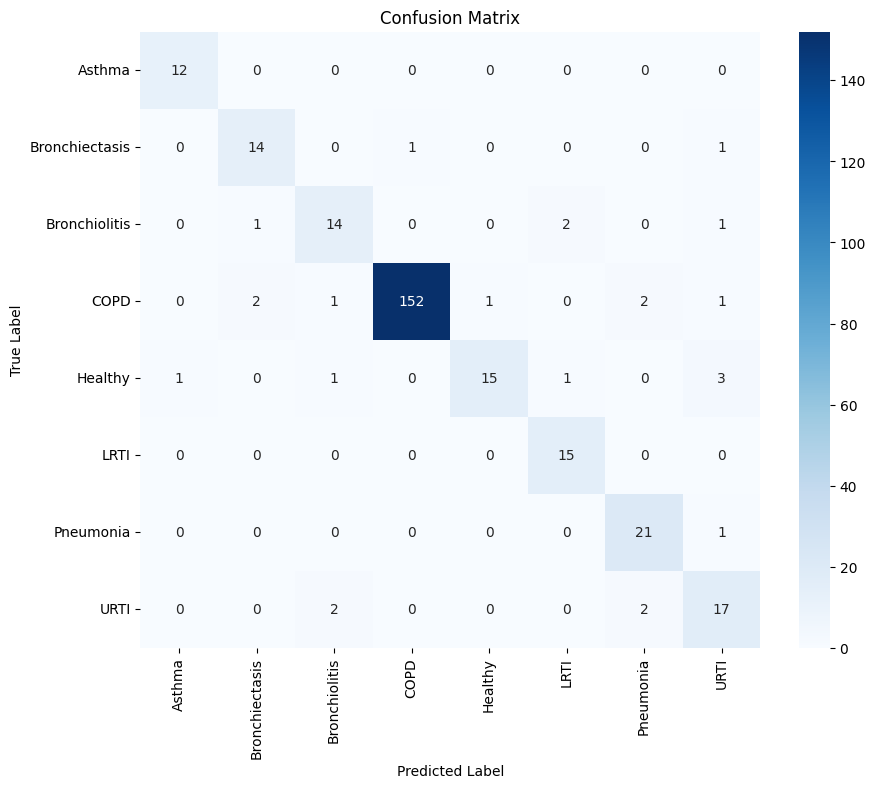

In [65]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Rapport Complet

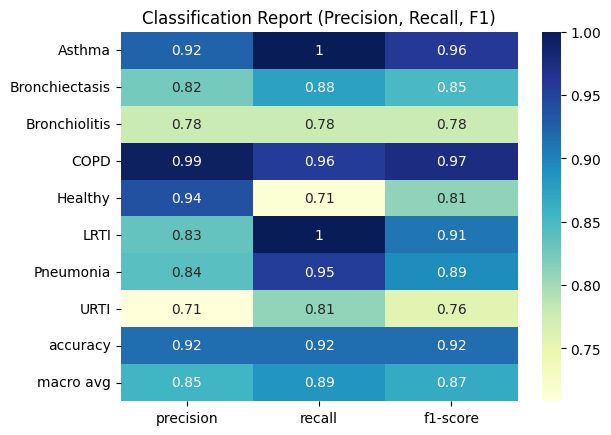

In [66]:
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
report_df = sns.heatmap(
    pd.DataFrame(report_dict).iloc[:-1, :-1].T,
    annot=True, cmap="YlGnBu"
)
plt.title("Classification Report (Precision, Recall, F1)")
plt.show()

# Prediction prep

In [56]:
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_resized = tf.image.resize(mel_db[..., np.newaxis], (IMG_HEIGHT, IMG_WIDTH)).numpy()
    mel_rgb = np.repeat(mel_resized, 3, axis=-1)  # Convert to 3 channels
    mel_rgb = np.expand_dims(mel_rgb, axis=0)  # Add batch dimension
    return mel_rgb

def predict(file_path):
    input_data = preprocess_audio(file_path)

    prediction = model.predict(input_data)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    print(f"Predicted class: {predicted_label[0]}")

# Testing Asthma
We started to test with asthma because it is the less abondant class (originally 20 seconds)

In [53]:
predict("./ICBHI_final_database_preprocessed_normalized/103_2b2_Ar_mc_LittC2SE_aug_4.wav")

1/1 [==============================] - 0s 29ms/step
Predicted class: Asthma


# Testing LRTI 
it is the second less abondant class originally about 40 seconds

In [54]:
predict("./ICBHI_final_database_preprocessed_normalized/108_1b1_Al_sc_Meditron_aug_1.wav")

1/1 [==============================] - 0s 29ms/step
Predicted class: LRTI
